# Generate single-cell images

Here, we are going to process the previously ingested microscopy images with the [scPortrait](https://github.com/MannLabs/scPortrait) pipeline to generate single-cell images that we can use to asses autophagosome formation at a single-cell level.

In [42]:
import lamindb as ln
import h5py

from typing import Iterable

from pathlib import Path
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
import spatialdata_plot
import h5py
import matplotlib.pyplot as plt
from spatialdata import to_polygons

ln.track()

→ loaded Transform('9gzJFsXw1f6N0001'), re-started Run('MwMPcQpl...') at 2025-02-28 19:12:45 UTC
→ notebook imports: h5py==3.13.0 lamindb==1.1.1 matplotlib==3.10.0 scportrait==1.1.1.dev0 spatialdata==0.3.0 spatialdata_plot==0.2.9


First, we query for the raw and annotated microscopy images.

In [2]:
input_images = (
    ln.Artifact.filter(ulabels__name="autophagy imaging")
    .filter(description__icontains="raw image")
    .filter(suffix=".tif")
)

The experiment contains different genotypes (`WT` and `EI24KO`) that were treated differently (`unstimulated` vs `14h Torin-1`).
For each condition multiple clonal cell lines and imaged multiple FOVs in all of the imaging channels are available.
To properly process this dataset we will need to get single-cell images from each FOV indivdually and tag them with all of the appropriate metadata so that we can identify genotype, treatment condition, clonal cell line and imaging experiment. 

In [3]:
conditions = [
    ln.ULabel.get(name=name)
    for name in set(af.features.get_values()["stimulation"] for af in input_images)
]
cell_line_clones = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["cell_line_clone"] for a in input_images)
]
FOVs = [
    ln.ULabel.get(name=name)
    for name in set(a.features.get_values()["FOV"] for a in input_images)
]

In [5]:
input_images[0].features.get_values()

# would be nice to be able to do something equivalent to
# input_images.features.get_values()

{'FOV': 'FOV1',
 'artefact type': 'input images',
 'artifact type': 'input images',
 'cell_line_clone': 'U2OS lcklip-mNeon mCherryLC3B clone 1',
 'channel': 'Alexa488',
 'genotype': 'WT',
 'imaged structure': 'LckLip-mNeon',
 'magnification': '20X',
 'microscope': 'Opera Phenix',
 'stimulation': '14h Torin-1',
 'study': 'autophagy imaging',
 'resolution': 0.597976081}

In [6]:
# this is not working as expected -> should have a lot more features
ln.Artifact.filter(ulabels__name="autophagy imaging").df(features=True)

,uid,key,description,study,resolution,number of single-cells
id,,,,,,
285,R4bcV3lBoE3KXD2q0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},{157.0}
209,P6r2aqhFZomH93uJ0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},{81.0}
276,nIl04jrthI5GNOX00000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},{105.0}
137,jP8M4lTmCX4A3xCs0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},{0.597976081},{71.0}
168,jEn1belfVUHZ2ki30000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},{0.597976081},{70.0}
...,...,...,...,...,...,...
188,S1vyYJFc9nAgOvRM0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},NaN,NaN
150,DkbGSFdQT3AXjqQt0000,None,single-cell image dataset of cells stained for...,{autophagy imaging},NaN,NaN
183,9ImieKkFxhw9F63L0000,input_data_imaging_usecase/images/Timepoint001...,raw image of U2OS cells stained for autophagy ...,{autophagy imaging},NaN,NaN


By iterating through conditions, celllines and FOVs, we should only have the images showing a single FOV in the 3 imaged channels.

In [7]:
number_of_channels = 3
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            assert len(images) == number_of_channels

We  process these individual FOVs by ingesting our common config file and processing the images in scPortrait.

In [13]:
# load config file for processing all datasets
config_file_af = ln.Artifact.get(key="input_data_imaging_usecase/config.yml")
config_file_af.description = (
    "config for scportrait for processing of cells stained for autophagy markers"
)
config_file_af.save()

# annotate the config file with the metadata relevant to the study
config_file_af.features.add_values(
    {"study": "autophagy imaging", "artifact type": "scportrait config"}
)

Lets take a look at the processing of one example image.

In [11]:
#get input images for one example FOV
condition = conditions[0]
cellline = cell_line_clones[0]
FOV = FOVs[0]

images = (
            input_images.filter(ulabels=condition)
            .filter(ulabels=cellline)
            .filter(ulabels=FOV)
            .distinct()
            )

# Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
_features = []
values_to_ignore = ["channel", "imaged structure"]

for af in images:
    features = af.features.get_values()
    features = {
        key: features[key] for key in features.keys() if key not in values_to_ignore
    }
    _features.append(features)
assert all([_features[0] == f for f in _features])
shared_features = _features[0]

# bring image paths into the correct order for processing
paths = [
        images.filter(ulabels__name=channel_name).one().cache()
        for channel_name in ["DAPI", "Alexa488", "mCherry"]
    ]


In [24]:
# define and create an output location for the processed data
output_directory = "processed_data"
Path(output_directory).mkdir(parents=True, exist_ok=True)

#initialize our scportrait project with a unique ID
unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
        " ", "_"
    )

# create the project location
project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
Path(project_location).mkdir(parents=True, exist_ok=True)

#initialize the project
project = Project(
    project_location=project_location,
    config_path=config_file_af.cache(),
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    overwrite=True,
)

# load our input images
project.load_input_from_tif_files(
    paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
)

#process the project
project.segment()
project.extract()

Updating project config file.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         processed_data/U2OS_lcklip-mNeon_mCherryLC3B_clone_1/14h_Torin-1/FOV1/scportrait_project/scportrait.sdata 


Extracting cell batches: 100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


scPortrait has generated two different results for us. The first are segmentation masks showing nucleus and cytosol.

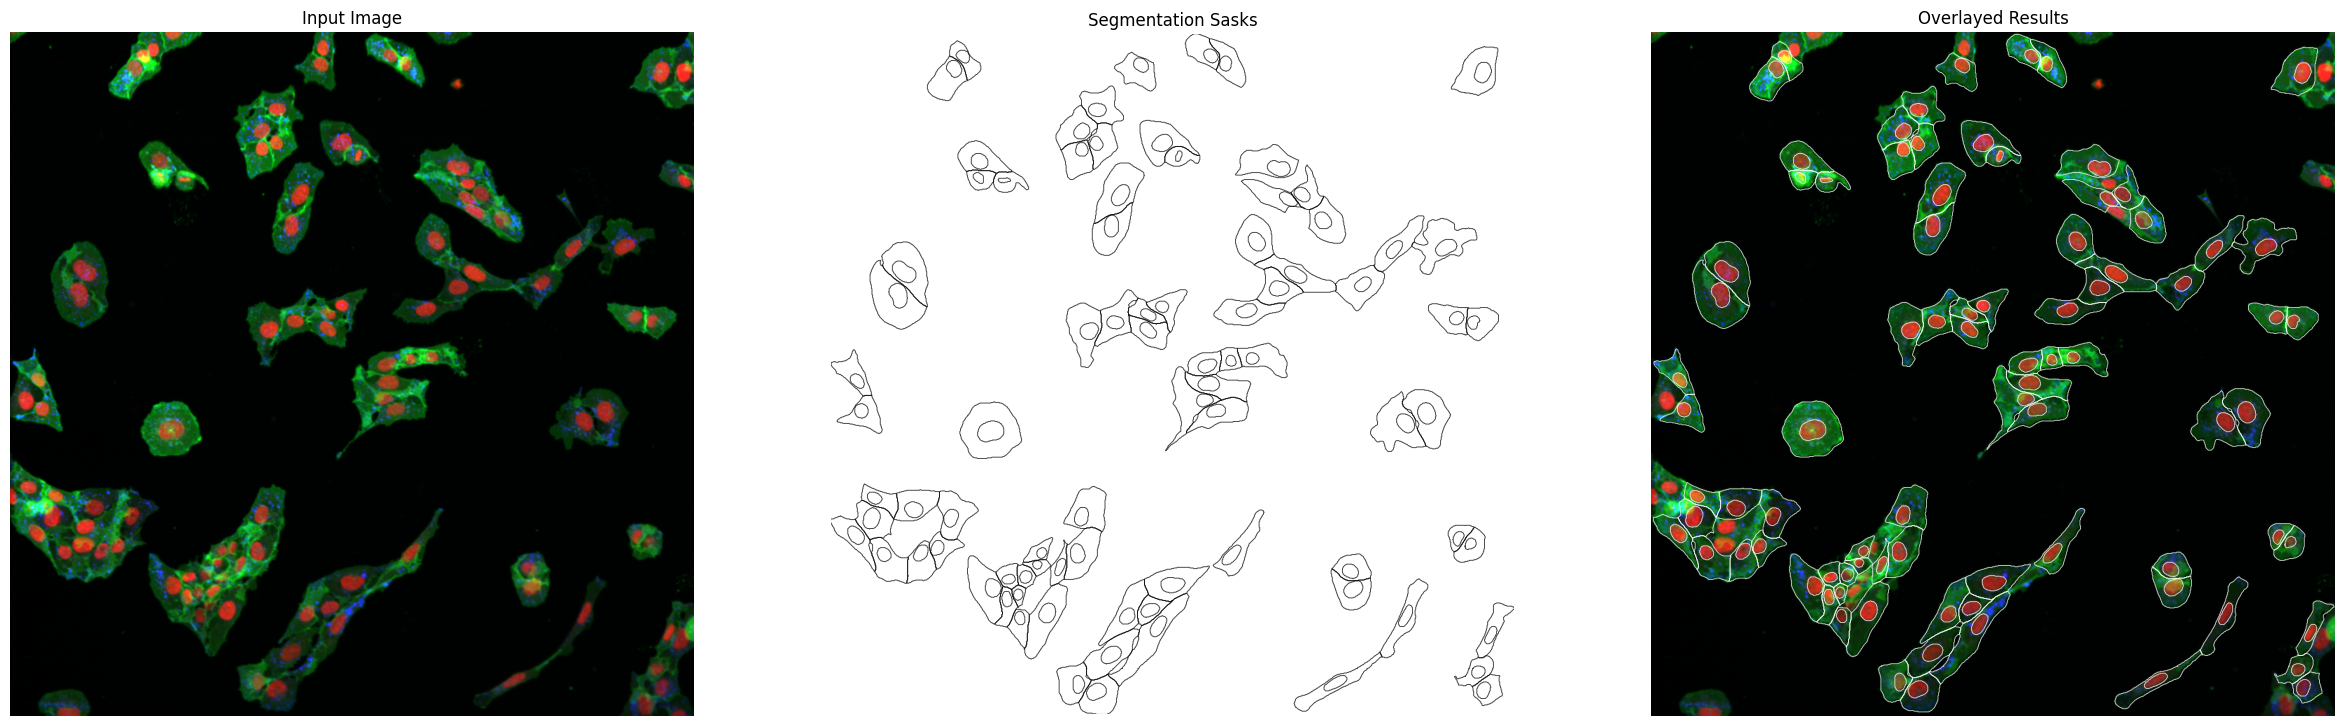

In [ ]:
sdata = project.sdata

# convert rasterized segmentation results to a vectorized format for prettier visualization
sdata["seg_all_nucleus_vectorized"] = to_polygons(sdata["seg_all_nucleus"])
sdata["seg_all_cytosol_vectorized"] = to_polygons(sdata["seg_all_cytosol"])

fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sdata.pl.render_images("input_image").pl.show(ax=axs[0], title="Input Image");
sdata.pl.render_shapes("seg_all_nucleus_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "black").pl.show(ax=axs[1], title="Segmentation Masks");
sdata.pl.render_shapes("seg_all_cytosol_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "black").pl.show(ax=axs[1], title="Segmentation Masks");

sdata.pl.render_images("input_image").pl.show(ax=axs[2], title="Input Image");
sdata.pl.render_shapes("seg_all_nucleus_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "white").pl.show(ax=axs[2], title="Segmentation Masks");
sdata.pl.render_shapes("seg_all_cytosol_vectorized", fill_alpha=0, outline_alpha=0.7, outline_width=0.7, outline_color = "white").pl.show(ax=axs[2], title="Overlayed Results");

axs[0].axis("off");
axs[1].axis("off");
axs[2].axis("off");

In addition we now also have a complete single-cell image dataset, were we have both the Mask Information as well as the pixel information for each imaged channel.

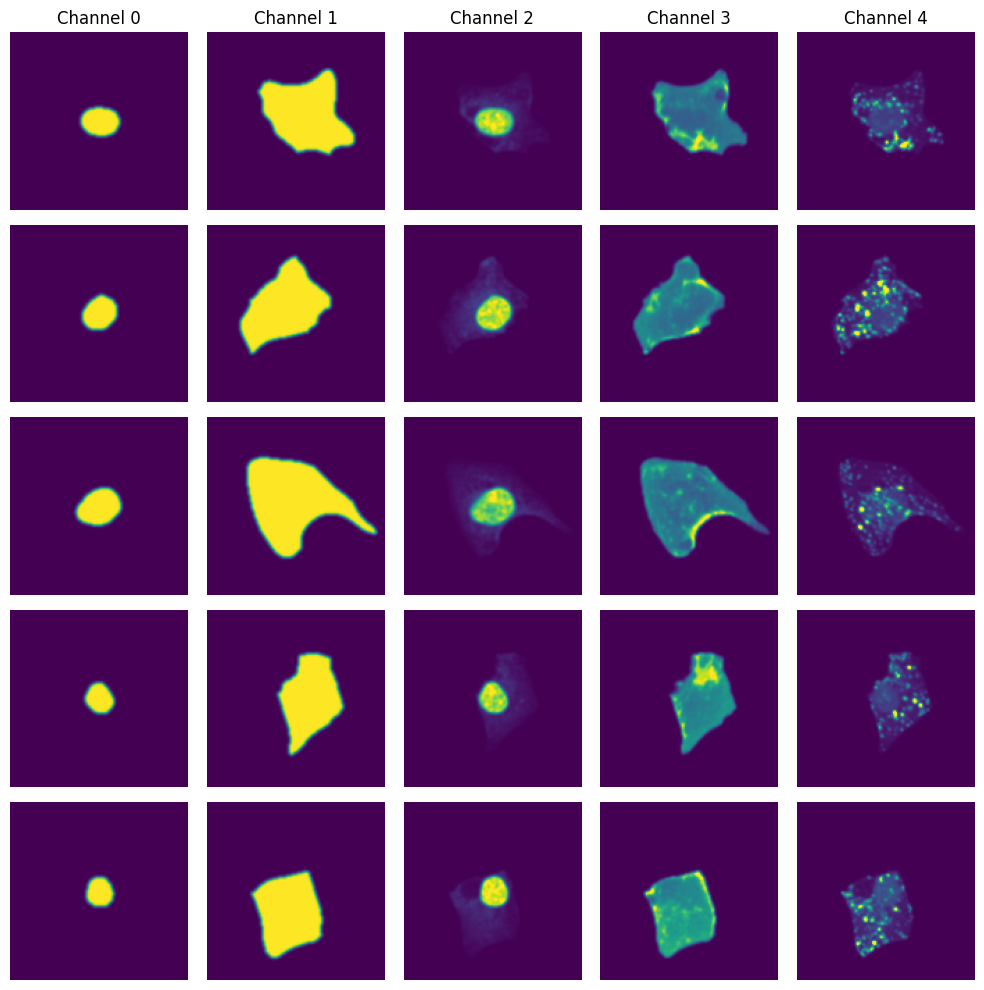

In [ ]:
single_cell_data = project.extraction_f.output_path
n_cells = 5

with h5py.File(single_cell_data, "r") as f:
    images = f['single_cell_data'][0:n_cells]

n_channels = 5
fig, axs = plt.subplots(n_channels, n_cells, figsize=(2 * n_channels, 2 * n_cells))

for i in range(n_cells):
    for j in range(n_channels):
        axs[i, j].imshow(images[i][j], vmin = 0, vmax = 1)
        axs[i, j].axis("off")

        if i == 0:
            axs[i, j].set_title(f"Channel {j}")

fig.tight_layout()


To make our lives easier so that we can process all of the files in our dataset we are going to write a custom image processing function.
We decorate this function with :func:`~lamindb.tracked` to track data lineage of the input and output Artifacts.

In [57]:
@ln.tracked()
def _process_images(
    config_file_af: ln.Artifact,
    input_artifacts: Iterable[ln.Artifact],
    output_directory: str,
) -> None:
    run_dummy_only = True
    if not run_dummy_only:
        # Perform quick sanity check that we only have images which share all of their attributed except channel and imaged structure
        _features = []
        values_to_ignore = ["channel", "imaged structure"]

        for af in input_artifacts:
            features = af.features.get_values()
            features = {
                key: features[key] for key in features.keys() if key not in values_to_ignore
            }
            _features.append(features)
        assert all([_features[0] == f for f in _features])
        shared_features = _features[0]

        # get the paths to the input images
        paths = [
            input_artifacts.filter(ulabels__name=channel_name).one().cache()
            for channel_name in ["DAPI", "Alexa488", "mCherry"]
        ]

        # create a unique identifier for the project based on the annotated features
        unique_project_id = f"{shared_features['cell_line_clone']}/{shared_features['stimulation']}/{shared_features['FOV']}".replace(
            " ", "_"
        )

        # create the project location
        project_location = f"{output_directory}/{unique_project_id}/scportrait_project"
        Path(project_location).mkdir(parents=True, exist_ok=True)

        project = Project(
            project_location=project_location,
            config_path=config_file_af.cache(),
            segmentation_f=CytosolSegmentationCellpose,
            extraction_f=HDF5CellExtraction,
            overwrite=True,
        )

        # process the project
        project.load_input_from_tif_files(
            paths, overwrite=True, channel_names=["DAPI", "Alexa488", "mCherry"]
        )
        project.segment()
        project.extract()

        # update the annotation to reflect the new data modality
        single_cell_images = f"{project_location}/extraction/data/single_cells.h5"
        annotation = shared_features
        annotation["filetype"] = "h5"  # update filetype to h5
        annotation["number of single-cells"] = h5py.File(single_cell_images, "r")[
            "single_cell_index"
        ].shape[0]
        annotation["channel"] = [
            ln.ULabel.get(name=channel_name)
            for channel_name in ["DAPI", "mCherry", "Alexa488"]
        ]
        annotation["imaged structure"] = [
            ln.ULabel.get(name=structure_name)
            for structure_name in ["LckLip-mNeon", "DNA", "mCherry-LC3B"]
        ]

        artifact = ln.Artifact(
            single_cell_images,
            description="single-cell image dataset of cells stained for autophagy markers",
        )
        artifact.save()
        artifact.features.add_values(annotation)
        artifact.labels.add(ln.ULabel.get(name="scportrait single-cell images"))


ln.Param(name="output_directory", dtype="str").save()

→ returning existing Param record with same name: 'output_directory'


Param(name='output_directory', dtype='str', is_type=False, created_by_id=4, run_id=28, space_id=1, created_at=2025-02-05 14:37:33 UTC)

Now we are ready to process all of our input images and upload the generated single-cell image datasets back to lamin.

In [58]:
for condition in conditions:
    for cellline in cell_line_clones:
        for FOV in FOVs:
            images = (
                input_images.filter(ulabels=condition)
                .filter(ulabels=cellline)
                .filter(ulabels=FOV)
                .distinct()
            )
            _process_images(
                config_file_af,
                input_artifacts=images,
                output_directory=output_directory,
            )

! cannot infer feature type of: <QuerySet [Artifact(uid='D78mnvc00leUXchR0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_Alexa488_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='0aoXxT857VvKAGo9UQo-8g', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:39 UTC), Artifact(uid='cWztVN7NE7nRxbzi0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_DAPI_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='YRjhTt2cBLq3BukWLUKC_w', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:31:48 UTC), Artifact(uid='mpVzuhV5BdmvXV080000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row01_Well01_mCherry_zstack001_r003_c005.tif', description='raw image of U2OS cells stained for autophagy ma

! The following artifacts are both inputs and outputs of Run(uid=u6S41BHOmt5H3qkRcAYj): {Artifact(uid='Oxa5oKf4zUU6NDQw0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_Alexa488_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='5cfc02GejBaoJ0h3OLWSdw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:22 UTC), Artifact(uid='7nle3IqVf76F1xp90000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_DAPI_zstack001_r002_c009.tif', description='raw image of U2OS cells stained for autophagy markers', suffix='.tif', size=2333056, hash='CmAa139DH_lQ2Plcy4BxXw', space_id=1, storage_id=1, run_id=108, created_by_id=4, created_at=2025-02-05 12:32:26 UTC), Artifact(uid='OKdwPqnoJ1blWYFQ0000', is_latest=True, key='input_data_imaging_usecase/images/Timepoint001_Row02_Well08_mCherry_zstack001_r002_c009.tif', description='ra

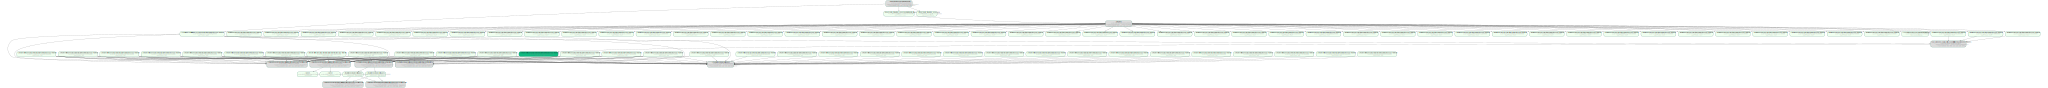

In [59]:
example_artifact = ln.Artifact.filter(
    ulabels=ln.ULabel.get(name="scportrait single-cell images")
)[0]
example_artifact.view_lineage()

In [60]:
ln.finish()

• please hit CMD + s to save the notebook in your editor .. ✓
! cells [(0, 42), (42, 2), (3, 5), (7, 13), (13, 11), (11, 24), (24, 52), (52, None), (None, 57)] were not run consecutively
→ finished Run('MwMPcQpl') after 7m at 2025-02-28 19:19:45 UTC
→ go to: https://lamin.ai/scportrait/examples/transform/9gzJFsXw1f6N0001
→ to update your notebook from the CLI, run: lamin save /Users/sophia/Documents/GitHub/lamin-usecases/docs/imaging2.ipynb
